# Setup

## Imports

In [69]:
import pandas as pd
import numpy as np
import sagemaker
import boto3
import dotenv
import os
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sagemaker import Session
from sagemaker import image_uris
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
from sagemaker.model import Model

## Variaveis de ambiente

In [3]:
dotenv.load_dotenv()
role = os.getenv("ROLE")

if role is None:
    raise ValueError("Please set the ROLE environment variable to your SageMaker role ARN.")

## Importando os arquivos necessários

In [4]:
path_dataframe = "house_prices.csv"
if not os.path.exists(path_dataframe):
    print("Please download the house_prices.csv file from the provided link.")
    print("https://drive.google.com/file/d/1UiKVvn2gEVvW-I-pim7q5rnf6FKMp4-2/view?usp=drive_link")
    exit(1)

In [5]:
df = pd.read_csv(path_dataframe)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.corr(numeric_only=True)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


## Tratamento da base de dados

In [7]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [8]:
df.drop(columns=["id"], inplace=True, axis=1)
df.drop(columns=["date"], inplace=True, axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Separando dados de treino e teste

In [9]:
base_treinamento = df.sample(frac=0.8, random_state=1)
base_teste = df.drop(base_treinamento.index)
base_treinamento.shape, base_teste.shape

((17290, 19), (4323, 19))

In [10]:
base_treinamento.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15544,459000.0,4,2.75,2790,6600,2.0,0,0,3,9,2790,0,2000,0,98058,47.4362,-122.109,2900,6752
17454,445000.0,3,2.25,1630,6449,1.0,0,0,3,7,1310,320,1986,0,98011,47.7275,-122.232,1620,7429
21548,1057000.0,2,1.50,2370,184231,2.0,0,0,3,11,2370,0,2005,0,98045,47.4543,-121.778,3860,151081
3427,732350.0,4,2.50,2270,7665,2.0,0,0,3,9,2270,0,1986,0,98052,47.6612,-122.148,2450,8706
8809,235000.0,3,1.00,1430,7599,1.5,0,0,4,6,1010,420,1930,0,98168,47.4783,-122.265,1290,10320


In [11]:
base_teste.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14,530000.0,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850
15,650000.0,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140,4000
18,189000.0,2,1.00,1200,9850,1.0,0,0,4,7,1200,0,1921,0,98002,47.3089,-122.210,1060,5095
20,385000.0,4,1.75,1620,4980,1.0,0,0,4,7,860,760,1947,0,98133,47.7025,-122.341,1400,4980
27,667000.0,3,1.00,1400,1581,1.5,0,0,5,8,1400,0,1909,0,98112,47.6221,-122.314,1860,3861


In [12]:
path_base_treinamento = "base_treinamento.csv"
path_base_teste = "base_teste.csv"

base_treinamento.to_csv(path_base_treinamento, index=False, header=False)
base_teste.to_csv(path_base_teste, index=False, header=False)

In [13]:
x_train = base_treinamento.drop(columns=["price"], axis=1)
y_train = base_treinamento["price"]
x_train.shape, y_train.shape

((17290, 18), (17290,))

In [14]:
x_test = base_teste.drop(columns=["price"], axis=1)
y_test = base_teste["price"]
x_test.shape, y_test.shape

((4323, 18), (4323,))

# Setup SageMaker

## Subindo dados de treinamento para o S3

In [67]:
session = Session()
bucket = session.default_bucket()
bucket_inst = boto3.resource("s3").Bucket(bucket)
bucket_inst.name

'sagemaker-us-east-1-022499002098'

In [16]:
subpasta_dataset = "datasets/house_prices/xgboost"
subpasta_model = "models/house_prices/xgboost"

key_trainamento = "house_prices_train"
key_teste = "house_prices_test"

In [17]:
with open(path_base_treinamento, "rb") as f:
    bucket_inst.upload_fileobj(f, os.path.join(subpasta_dataset, key_trainamento))
    
with open(path_base_teste, "rb") as f:
    bucket_inst.upload_fileobj(f, os.path.join(subpasta_dataset, key_teste))

## Treinando o modelo

In [18]:
container = image_uris.retrieve(
    region=session.boto_region_name,
    framework="xgboost",
    version="1.0-1",
)

xgboost = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path=f"s3://{bucket}/{subpasta_model}",
    sagemaker_session=session,
)

xgboost.set_hyperparameters(num_round=100)

In [19]:
train_input = f"s3://{bucket}/{subpasta_dataset}/{key_trainamento}"
test_input = f"s3://{bucket}/{subpasta_dataset}/{key_teste}"

train_input = sagemaker.inputs.TrainingInput(
    s3_data=train_input,
    content_type="csv",
    s3_data_type="S3Prefix",
)

validation_input = sagemaker.inputs.TrainingInput(
    s3_data=test_input,
    content_type="csv",
    s3_data_type="S3Prefix",
)

data_channels = {
    "train": train_input,
    "validation": validation_input,
}

In [20]:
xgboost.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-05-14-18-43-57-343


2025-05-14 18:44:00 Starting - Starting the training job...
2025-05-14 18:44:34 Downloading - Downloading input data...
2025-05-14 18:44:49 Downloading - Downloading the training image...
2025-05-14 18:45:25 Training - Training image download completed. Training in progress...[2025-05-14 18:45:48.763 ip-10-2-77-7.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[18:45:48] 17290x18 matrix with 311220 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[18:45:48] 4323x1

In [22]:
xgboost_regressor = xgboost.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name="house-prices-xgboost",
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-05-14-19-54-27-236
INFO:sagemaker:Creating endpoint-config with name house-prices-xgboost
INFO:sagemaker:Creating endpoint with name house-prices-xgboost


----------!

In [37]:
xgboost_regressor.serializer = CSVSerializer()
xgboost_regressor.deserializer = CSVDeserializer()

In [55]:
y_predict = xgboost_regressor.predict(x_test)

In [58]:
y_test_np = np.array(y_test, dtype=float)
y_predict_np = np.array(y_predict, dtype=float).flatten()
y_predict_np.shape, y_test_np.shape

((4323,), (4323,))

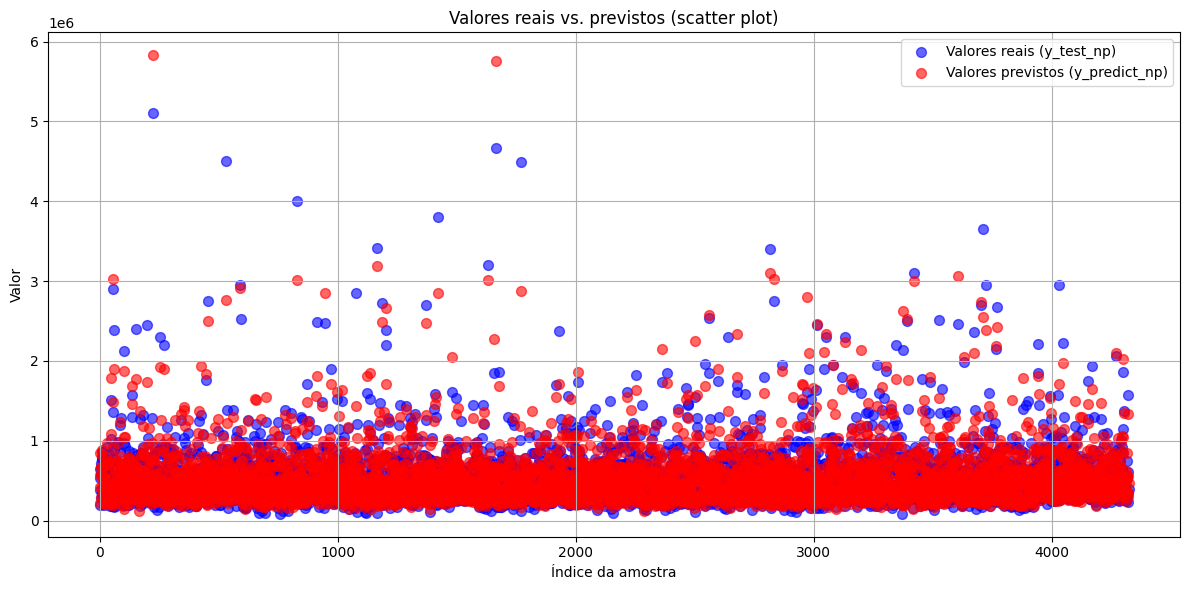

In [ ]:
indices = np.arange(len(y_test_np))
plt.figure(figsize=(12, 6))

plt.scatter(indices, y_test_np, color='blue', label='Valores reais (y_test_np)', alpha=0.6, s=50)
plt.scatter(indices, y_predict_np, color='red', label='Valores previstos (y_predict_np)', alpha=0.6, s=50)

plt.title('Valores reais vs. previstos (scatter plot)')
plt.xlabel('Índice da amostra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

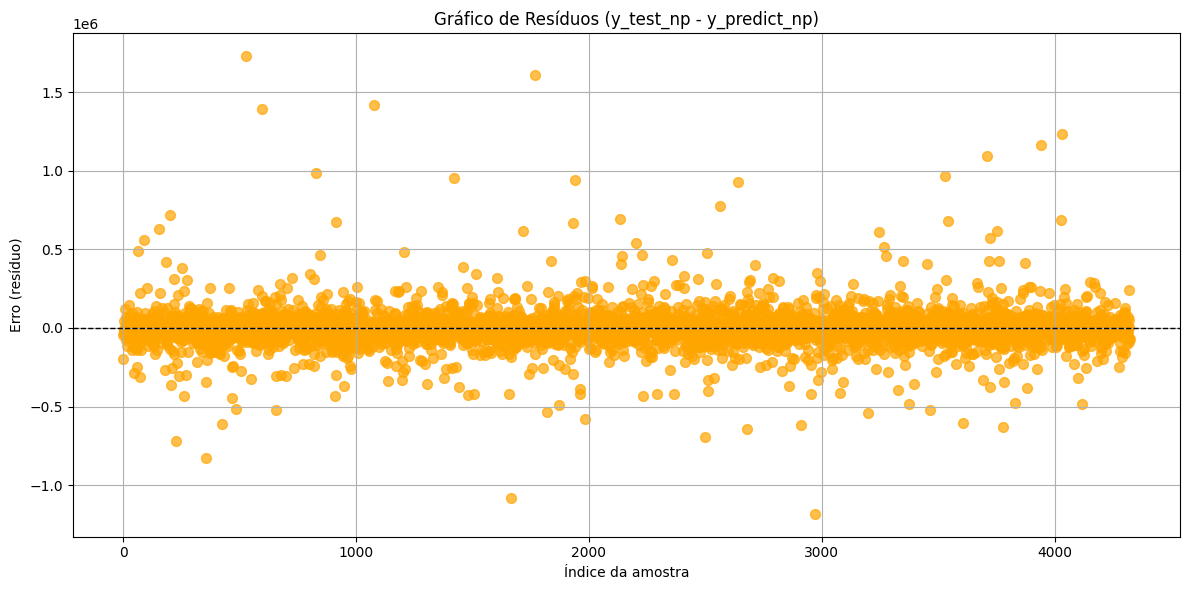

In [62]:
residuos = y_test_np - y_predict_np

plt.figure(figsize=(12, 6))
plt.scatter(indices, residuos, color='orange', alpha=0.7, s=50)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Gráfico de Resíduos (y_test_np - y_predict_np)')
plt.xlabel('Índice da amostra')
plt.ylabel('Erro (resíduo)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
mae = mean_absolute_error(y_test_np, y_predict_np)
mse = mean_squared_error(y_test_np, y_predict_np)
print('MAE = ', mae, '\nMSE = ', mse)

MAE =  70755.5390932223 
MSE =  16409876145.874443


In [65]:
xgboost_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: house-prices-xgboost
INFO:sagemaker:Deleting endpoint with name: house-prices-xgboost


In [72]:
container = image_uris.retrieve(
    region=session.boto_region_name,
    framework="xgboost",
    version="1.0-1",
)

model = Model(
    model_data="s3://sagemaker-us-east-1-022499002098/models/house_prices/xgboost/sagemaker-xgboost-2025-05-14-18-43-57-343/output/model.tar.gz",
    image_uri=container,
    role=role,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [ ]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name='house-prices-xgboost-model',
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer()
)

In [ ]:
client = boto3.client('sagemaker')
endpoints = client.list_endpoints()['Endpoints']

for ep in endpoints:
    name = ep['EndpointName']
    client.delete_endpoint(EndpointName=name)
